In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
sns.set_style("darkgrid")
sns.set_context("notebook")
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["dir", "/b", "/a-d","input"], shell=True).decode("utf8"))

# Any results you write to the current directory are saved as output.

BBTeamSeasonStats.csv
RegularSeasonCompactResults.csv
RegularSeasonDetailedResults.csv
SampleSubmission.csv
Seasons.csv
Teams.csv
TourneyCompactResults.csv
TourneyDetailedResults.csv
TourneySeeds.csv
TourneySlots.csv



Set some constants we need to compute Elo ratings

In [19]:
mean_elo = 1500
elo_width = 400
k_factor = 64

## Load the data ##

In [20]:
data_dir = 'input/'

In [21]:
df_reg = pd.read_csv(data_dir + 'RegularSeasonCompactResults.csv')
df_tour = pd.read_csv(data_dir + 'TourneyCompactResults.csv')

- Concatenate both regular season and tournament results into one DataFrame.
- Drop the columns we don't need. 
- Sort chronologically, ie by season, then by date in that season

In [34]:
df_concat = pd.concat((df_reg, df_tour), ignore_index=True)
df_concat.drop(labels=[ 'Wscore', 'Lscore', 'Wloc', 'Numot'], inplace=True, axis=1)
df_concat.sort_values(by=['Season', 'Daynum'], inplace=True)
df_concat.head()

,Season,Daynum,Wteam,Lteam
0,1985,20,1228,1328
1,1985,25,1106,1354
2,1985,25,1112,1223
3,1985,25,1165,1432
4,1985,25,1192,1447


Transform team IDs to be from 0 to number_of_teams-1.
We do this so that we can use team ID as an index for lookups later.

In [23]:
le = LabelEncoder()
df_concat.Wteam = le.fit_transform(df_concat.Wteam)
df_concat.Lteam = le.fit_transform(df_concat.Lteam)

## Elo stuff preparation ##
Define the functions we need to calculate the probability of winning given two Elo ratings,
and also the change in Elo rating after a game is played.

In [24]:
def update_elo(winner_elo, loser_elo):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expected_win = expected_result(winner_elo, loser_elo)
    change_in_elo = k_factor * (1-expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo

def expected_result(elo_a, elo_b):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expect_a = 1.0/(1+10**((elo_b - elo_a)/elo_width))
    return expect_a

In [25]:
def update_end_of_season(elos):
    """Regression towards the mean
    
    Following 538 nfl methods
    https://fivethirtyeight.com/datalab/nfl-elo-ratings-are-back/
    """
    diff_from_mean = elos - mean_elo
    elos -= diff_from_mean/3
    return elos

In [26]:
df_concat['w_elo_before_game'] = 0
df_concat['w_elo_after_game'] = 0
df_concat['l_elo_before_game'] = 0
df_concat['l_elo_after_game'] = 0
elo_per_season = {}
n_teams = len(le.classes_)
current_elos = np.ones(shape=(n_teams)) * mean_elo

# Make a new column with a unique time
I use days since Jan 1, 1970 to be able to convert to a datetime object later

In [27]:
df_concat['total_days'] = (df_concat.Season-1970)*365.25 + df_concat.Daynum

In [28]:
df_team_elos = pd.DataFrame(index=df_concat.total_days.unique(), 
                            columns=range(n_teams))
df_team_elos.iloc[0, :] = current_elos

## The loop where it happens ##

- We go through each row in the DataFrame. 
- We look up the current Elo rating of both teams. 
- We calculate the expected wins for the team that *actually won*. This is also what we use for *probability of winning*.
- Write Elo before and after the game in the Data Frame. 
- Update the Elo rating for both teams in the "current_elos" list.

In [29]:
current_season = df_concat.at[0, 'Season']
for row in df_concat.itertuples():
    if row.Season != current_season:
        # Check if we are starting a new season. 
        # Regress all ratings towards the mean
        current_elos = update_end_of_season(current_elos)
        # Write the beginning of new season ratings to a dict for later lookups.
        elo_per_season[row.Season] = current_elos.copy()
        current_season = row.Season
    idx = row.Index
    w_id = row.Wteam
    l_id = row.Lteam
    # Get current elos
    w_elo_before = current_elos[w_id]
    l_elo_before = current_elos[l_id]
    # Update on game results
    w_elo_after, l_elo_after = update_elo(w_elo_before, l_elo_before)
        
    # Save updated elos
    df_concat.at[idx, 'w_elo_before_game'] = w_elo_before
    df_concat.at[idx, 'l_elo_before_game'] = l_elo_before
    df_concat.at[idx, 'w_elo_after_game'] = w_elo_after
    df_concat.at[idx, 'l_elo_after_game'] = l_elo_after
    current_elos[w_id] = w_elo_after
    current_elos[l_id] = l_elo_after
    
    # Save elos to team DataFrame
    today = row.total_days
    df_team_elos.at[today, w_id] = w_elo_after
    df_team_elos.at[today, l_id] = l_elo_after


## Evaluation ##
Sample 10,000 games from recent seasons. 
Record the expected wins and use this to calculate the logloss.

In [30]:
n_samples = 10000
samples = df_concat[df_concat.Season > 2010].sample(n_samples)
loss=0
expected_list = []
for row in samples.itertuples():
    w_elo = row.w_elo_before_game
    l_elo = row.l_elo_before_game
    w_expected = expected_result(w_elo, l_elo)
    expected_list.append(w_expected)
    loss += np.log(w_expected)
print(loss/n_samples)

-0.563906169246


Text(0,0.5,'Counts')

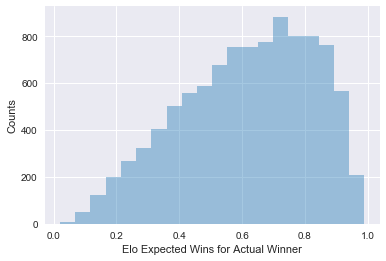

In [31]:
sns.distplot(expected_list, kde=False, bins=20)
plt.xlabel('Elo Expected Wins for Actual Winner')
plt.ylabel('Counts')

## Look at Elo ratings over time ##

- Fill all the N/As with the previous Elo rating. 
- Rename the columns to a string
- Make a new column with the datetime of the game

In [32]:
df_team_elos.fillna(method='ffill', inplace=True)
trans_dict = {i: 'team_{}'.format(i) for i in range(n_teams)}
df_team_elos.rename(columns=trans_dict, inplace=True)
epoch = (df_team_elos.index)
df_team_elos['date'] = pd.to_datetime(epoch, unit='D')

Text(0,0.5,'Elo rating')

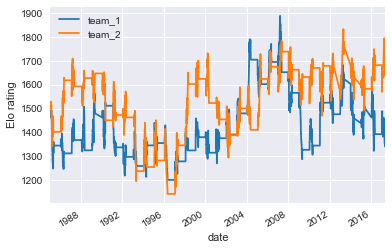

In [33]:
df_team_elos.plot(x='date', y=['team_1', 'team_2'])
plt.ylabel('Elo rating')